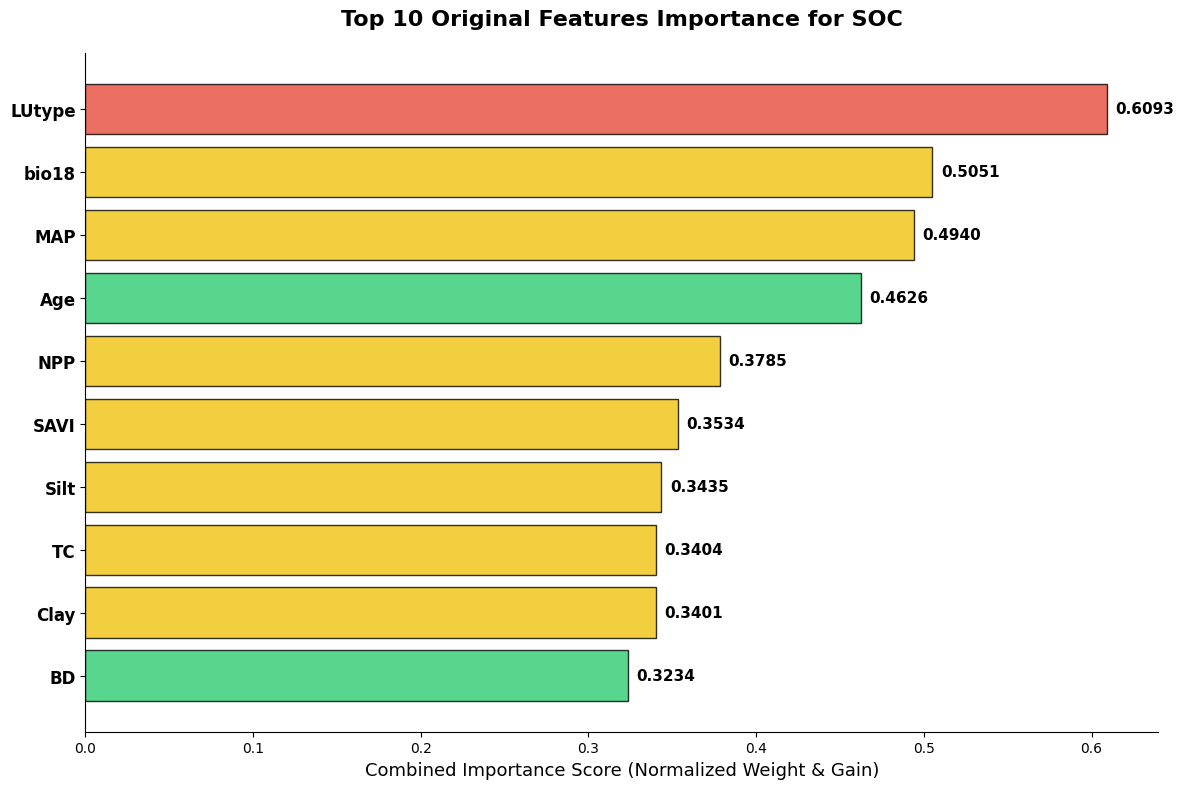


分析完成！
1. 总特征数: 46
2. 筛选出的原始特征数: 33
3. 图片保存至: F:/model/results/sixth/SOC_top/Feature_Importance_Final\top10_original_importance.png

--- Top 10 原始特征排名 ---
  feature  importance
0  LUtype    0.609264
1   bio18    0.505133
2     MAP    0.494038
3     Age    0.462573
4     NPP    0.378455
5    SAVI    0.353367
6    Silt    0.343524
7      TC    0.340406
8    Clay    0.340130
9      BD    0.323403


In [2]:
#####total PDP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. 路径设置与数据加载
# ==========================================
# 请根据实际情况修改路径
model_path = r'F:/model/results/sixth/SOC_top/xgb_model.json'
feature_names_path = r'F:/model/results/sixth/SOC_top/feature_names.txt'
output_dir = r'F:/model/results/sixth/SOC_top/Feature_Importance_Final'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 加载特征名
with open(feature_names_path, 'r') as f:
    model_features = [line.strip() for line in f.readlines() if line.strip()]

# 加载模型
bst = xgb.Booster()
bst.load_model(model_path)

# ==========================================
# 2. 原始特征筛选逻辑
# ==========================================
def extract_original_features(feature_list):
    """
    从模型特征中剔除所有带后缀的衍生变量，仅保留原始物理/环境特征
    """
    excluded_patterns = ['_log', '_interaction', '_boost', '_squared', '_bins']
    original_features = []
    for feat in feature_list:
        if not any(pattern in feat for pattern in excluded_patterns):
            original_features.append(feat)
    return original_features

original_features = extract_original_features(model_features)

# ==========================================
# 3. 计算综合重要性 (Weight & Gain)
# ==========================================
def get_combined_importance(model):
    # 获取不同类型的重要性得分
    weight_score = model.get_score(importance_type='weight')
    gain_score = model.get_score(importance_type='gain')
    
    # 转换为 DataFrame
    df_w = pd.DataFrame({'feature': list(weight_score.keys()), 'weight': list(weight_score.values())})
    df_g = pd.DataFrame({'feature': list(gain_score.keys()), 'gain': list(gain_score.values())})
    
    # 合并并归一化
    combined = pd.merge(df_w, df_g, on='feature', how='outer').fillna(0)
    combined['weight_norm'] = combined['weight'] / combined['weight'].max()
    combined['gain_norm'] = combined['gain'] / combined['gain'].max()
    
    # 计算综合得分 (50% 频率 + 50% 增益贡献)
    combined['importance'] = (combined['weight_norm'] + combined['gain_norm']) / 2
    return combined.sort_values('importance', ascending=False)

full_importance_df = get_combined_importance(bst)

# ==========================================
# 4. 筛选原始特征并取 Top 10
# ==========================================
# 仅保留原始特征列表中的项
original_imp_df = full_importance_df[full_importance_df['feature'].isin(original_features)].copy()
top10_original = original_imp_df.head(10).reset_index(drop=True)

# ==========================================
# 5. 绘图美化与保存
# ==========================================
def plot_importance_top10(df, title, save_path):
    plt.figure(figsize=(12, 8), dpi=100)
    
    # 倒序排列以便在条形图中最高分在最上方
    plot_data = df.iloc[::-1] 
    
    # 根据特征名称分配颜色 (可根据实际需求调整关键字)
    colors = []
    for feat in plot_data['feature']:
        if 'LUtype' in feat: colors.append('#e74c3c')    # 红色 (土地利用)
        elif feat in ['Age', 'BD', 'pH']: colors.append('#2ecc71') # 绿色 (关键因子)
        elif feat in ['Lon', 'Lat']: colors.append('#3498db')      # 蓝色 (地理位置)
        else: colors.append('#f1c40f')                            # 黄色 (其他)

    bars = plt.barh(plot_data['feature'], plot_data['importance'], color=colors, edgecolor='black', alpha=0.8)
    
    # 添加数值标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                 f'{width:.4f}', va='center', fontsize=11, fontweight='bold')

    # 图形装饰
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Combined Importance Score (Normalized Weight & Gain)', fontsize=13)
    plt.yticks(fontsize=12, fontweight='bold')
    
    # 移除顶部和右侧边框
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# 执行绘图
save_png = os.path.join(output_dir, 'top10_original_importance.png')
plot_importance_top10(top10_original, 'Top 10 Original Features Importance for SOC', save_png)

# ==========================================
# 6. 保存数据结果
# ==========================================
top10_original.to_csv(os.path.join(output_dir, 'top10_original_features.csv'), index=False)

print("\n分析完成！")
print(f"1. 总特征数: {len(model_features)}")
print(f"2. 筛选出的原始特征数: {len(original_features)}")
print(f"3. 图片保存至: {save_png}")
print("\n--- Top 10 原始特征排名 ---")
print(top10_original[['feature', 'importance']])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import numpy as np

# ============================================================
# 1. 设置路径与基本配置
# ============================================================
li_dir = r'F:/model/results/LI/plots'
soc_dir = r'F:/model/results/third/1216current/plots'
save_path = r'F:/model/results/LI/plots'

if not os.path.exists(save_path):
    os.makedirs(save_path)

# 加载数据
df_li = pd.read_csv(os.path.join(li_dir, 'LI_PDP_Plotting_Data.csv'))
df_soc = pd.read_csv(os.path.join(soc_dir, 'SOC_PDP_Plotting_Data.csv'))

# 颜色与样式配置
# 根据要求：上土层蓝色，LI红色
COLOR_SOC_TOP = '#008fd5'  # 上土层 SOC 蓝色
COLOR_LI = '#4A0505'       # LI 统一红色
COLOR_SUBSOIL = '#FFC125'  # 下土层保留原色（或可按需修改）

# ============================================================
# 2. 绘图函数 (封装以减少重复代码)
# ============================================================
def plot_pdp_content(ax, df_soc, df_li, filter_col, filter_val, is_total=False):
    """
    绘制PDP曲线和Rug Plot
    """
    if is_total:
        s_soc = df_soc[df_soc['Source'] == 'Total_Plot']
        s_li = df_li[df_li['Source'] == 'Total_Plot']
    else:
        s_soc = df_soc[df_soc[filter_col] == filter_val]
        s_li = df_li[df_li[filter_col] == filter_val]

    for soil in ['Topsoil', 'Subsoil']:
        line_style = '-' if soil == 'Topsoil' else '--'
        # 上土层固定蓝色，下土层固定原色；但如果是LI，则颜色为红色
        color_soc = COLOR_SOC_TOP if soil == 'Topsoil' else COLOR_SUBSOIL
        
        # --- 绘制 SOC ---
        d_soc = s_soc[s_soc['SoilLayer'] == soil]
        if not d_soc.empty:
            ax.plot(d_soc['Age_Grid'], d_soc['PDP_Percent'], 
                    color=color_soc, linestyle=line_style, linewidth=5, label=f'SOC {soil}', zorder=3)
            ax.fill_between(d_soc['Age_Grid'], d_soc['PDP_Lower_Percent'], 
                            d_soc['PDP_Upper_Percent'], color=color_soc, alpha=0.1)
            
            # SOC Rug Plot (放在底部)
            # 假设数据中包含原始点 Age_Raw，若没有则用 Age_Grid 模拟演示
            rug_data = d_soc['Age_Grid'].unique() 
            ax.vlines(rug_data, ymin=-2, ymax=0, color=color_soc, linewidth=1, alpha=0.5, transform=ax.get_xaxis_transform())

        # --- 绘制 LI (红色) ---
        d_li = s_li[s_li['SoilLayer'] == soil]
        if not d_li.empty:
            ax.plot(d_li['Age_Grid'], d_li['PDP_Percent'], 
                    color=COLOR_LI, linestyle=line_style, linewidth=5, label=f'LI {soil}', zorder=4)
            ax.fill_between(d_li['Age_Grid'], d_li['PDP_Lower_Percent'], 
                            d_li['PDP_Upper_Percent'], color=COLOR_LI, alpha=0.1)
            
            # LI Rug Plot (放在 SOC Rug 的上方)
            rug_data_li = d_li['Age_Grid'].unique()
            ax.vlines(rug_data_li, ymin=0, ymax=2, color=COLOR_LI, linewidth=1, alpha=0.5, transform=ax.get_xaxis_transform())

# ============================================================
# 3. 执行绘制 - 总图
# ============================================================
plt.rcParams.update({'font.size': 38, 'axes.labelweight': 'bold', 'font.family': 'Arial'})
fig1, ax1 = plt.subplots(figsize=(14, 11))

plot_pdp_content(ax1, df_soc, df_li, None, None, is_total=True)

ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.set_xlabel('Stand age (years)')
ax1.set_ylabel('$\Delta$ (%)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(frameon=False, loc='upper right', fontsize=20, ncol=2)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'Combined_Total_PDP_Rug.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 4. 执行绘制 - 子图
# ============================================================
lu_types_to_plot = ["Natural forest", "Grassland", "Cropland", "Fallow", "Bareland", "Sandy"]
fig2, axes2 = plt.subplots(2, 3, figsize=(30, 18))
axes_flat = axes2.flatten()

for idx, lu_type in enumerate(lu_types_to_plot):
    ax = axes_flat[idx]
    plot_pdp_content(ax, df_soc, df_li, 'LUType', lu_type)
    
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.set_title(lu_type, fontsize=40, fontweight='bold')
    ax.set_xlabel('Age (Years)', fontsize=35)
    ax.set_ylabel('$\Delta$ (%)', fontsize=35)
    ax.tick_params(labelsize=35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig(os.path.join(save_path, 'Combined_Subplots_PDP_Rug.png'), dpi=300, bbox_inches='tight')

print(f"Success! Plots saved to: {save_path}")
plt.show()

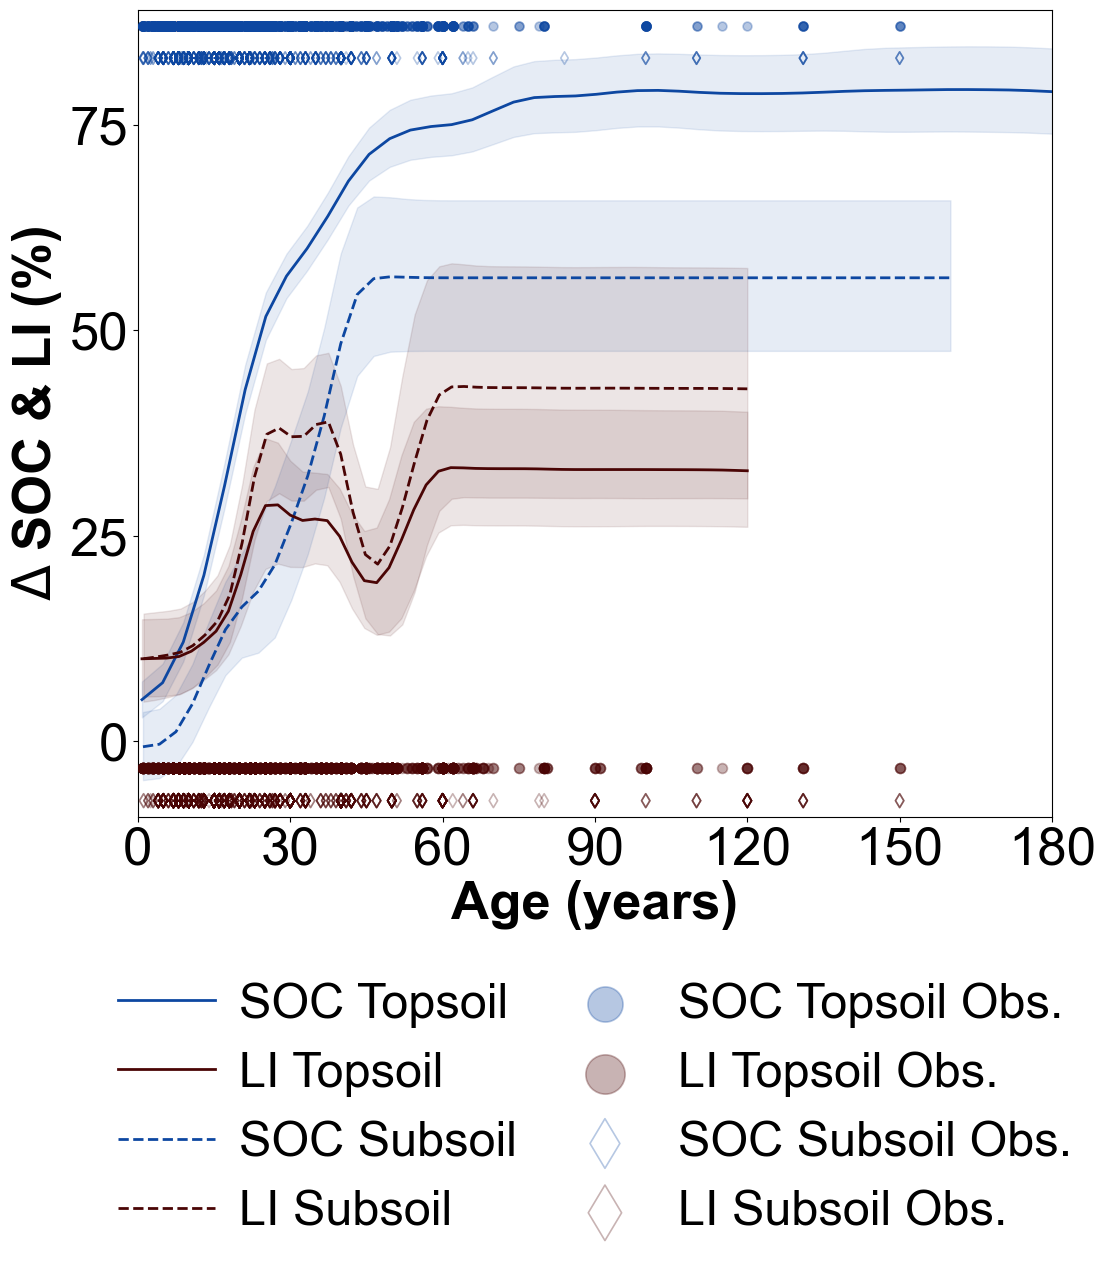

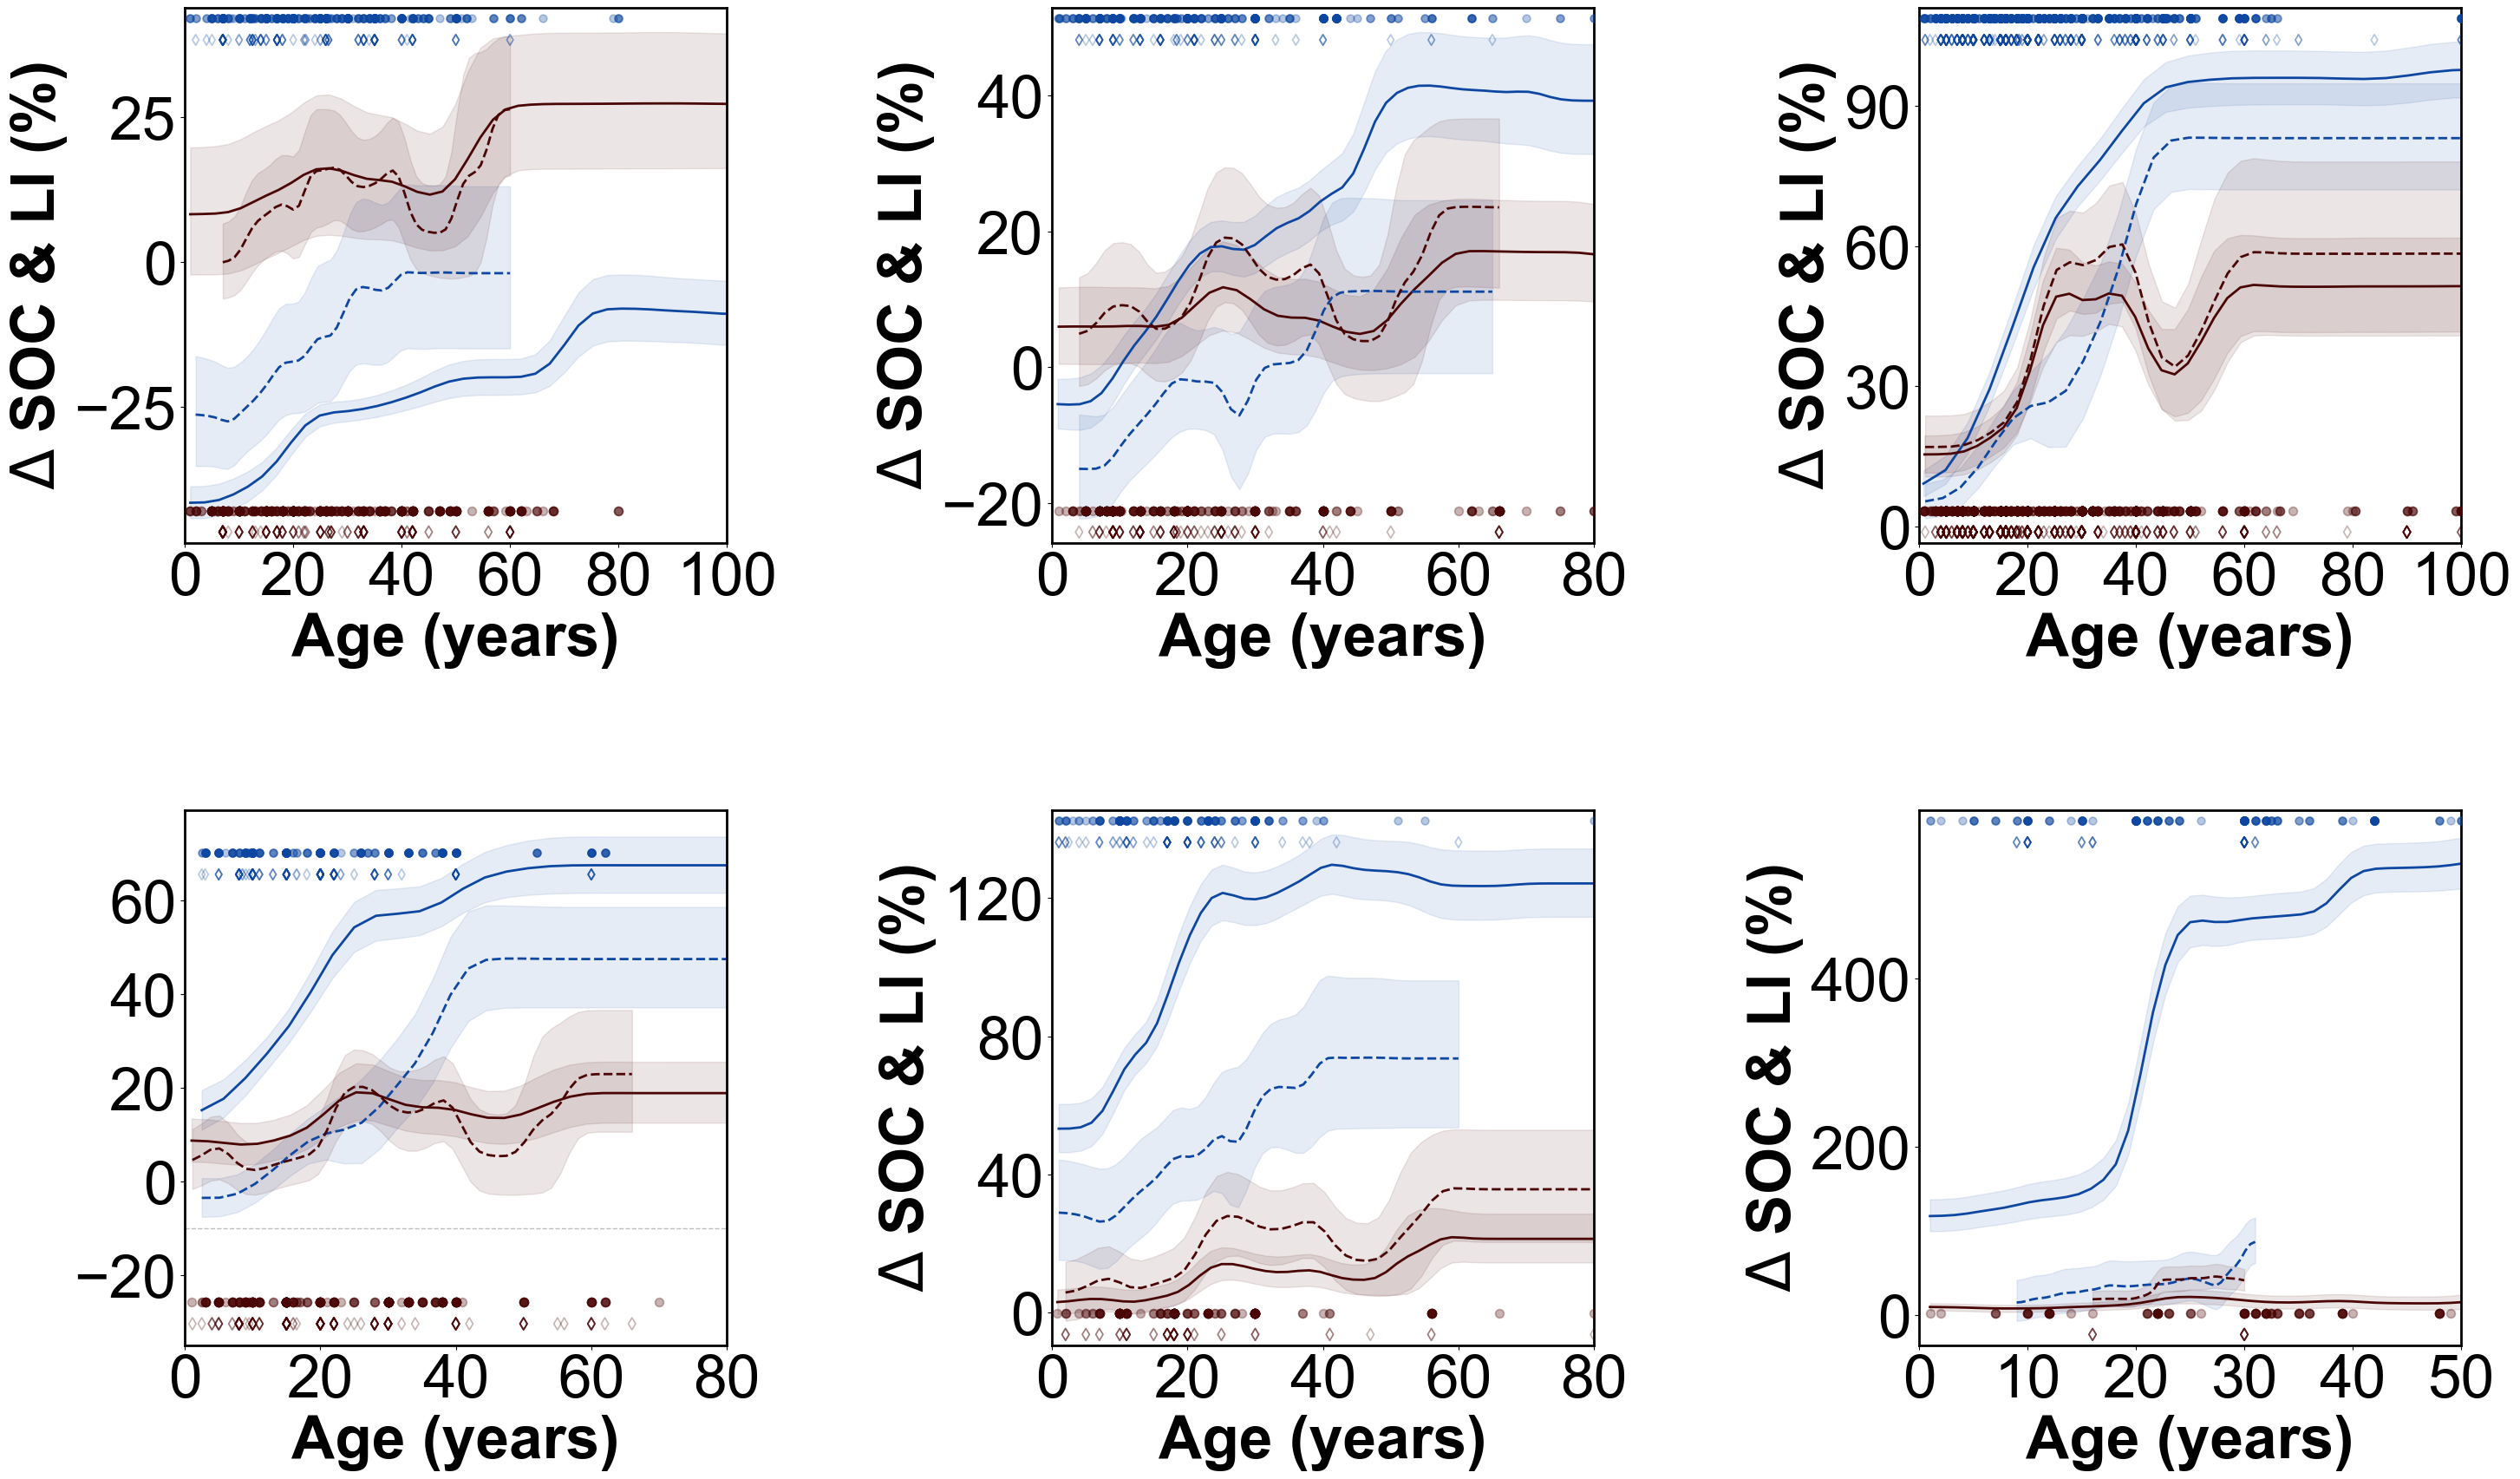

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import numpy as np

# ============================================================
# 1. 设置路径与数据加载
# ============================================================
soc_original_path = r'F:/model/df.clean.yi.csv'
li_original_path = r'F:/model/df.clean.yi.LI.csv'
li_dir = r'F:/model/results/LI/plots'
soc_dir = r'F:/model/results/sixth/plots'
save_path = r'F:/model/results/LI/plots'

if not os.path.exists(save_path):
    os.makedirs(save_path)

df_li_pdp = pd.read_csv(os.path.join(li_dir, 'LI_PDP_Plotting_Data.csv'))
df_soc_pdp = pd.read_csv(os.path.join(soc_dir, 'SOC_PDP_Plotting_Data.csv'))
df_soc_original = pd.read_csv(soc_original_path)
df_li_original = pd.read_csv(li_original_path)

df_soc_original.columns = df_soc_original.columns.str.strip()
df_li_original.columns = df_li_original.columns.str.strip()

age_col_original = 'Age'  
soil_layer_col_original = 'Soillayer'
lu_type_col_original = 'LUtype'
soil_layer_col_pdp = 'SoilLayer'
lu_type_col_pdp = 'LUType'

var_colors = {'SOC': '#0D47A1', 'LI': '#4A0505'}
soil_styles = {'Topsoil': '-', 'Subsoil': '--'}
lu_types_to_plot = ["Natural forest", "Grassland", "Cropland", "Fallow","Bareland",  "Sandy"]

# ============================================================
# 1.5 新增：数据处理函数 - 只删除观测点，不截断曲线
# ============================================================
def filter_observations_by_age(original_df, age_col='Age', cutoff_ages=None):
    """
    只删除原始观测数据中的尾部零星点，但不截断PDP曲线
    cutoff_ages: 字典，指定不同土地利用类型的截断年龄
    """
    if cutoff_ages is None:
        cutoff_ages = {}
    
    # 创建一个副本，避免修改原始数据
    df = original_df.copy()
    
    # 如果没有指定截断年龄，返回原始数据
    if not cutoff_ages:
        return df
    
    # 将土地利用类型代码映射到名称
    lu_map = {
        1: "Cropland", 2: "Natural forest", 3: "Grassland",
        4: "Bareland", 5: "Wetland", 6: "Fallow", 7: "Sandy"
    }
    
    # 创建一个掩码，标记哪些行需要保留
    mask = pd.Series(True, index=df.index)
    
    for lu_code, lu_name in lu_map.items():
        if lu_name in cutoff_ages:
            # 找到该土地利用类型的数据
            lu_data_mask = (df[lu_type_col_original] == lu_code)
            age_threshold = cutoff_ages[lu_name]
            
            # 标记超过年龄阈值的观测点
            age_exceed_mask = (df[age_col] > age_threshold) & lu_data_mask
            
            # 将这些观测点标记为False（不保留）
            mask = mask & ~age_exceed_mask
    
    return df[mask].reset_index(drop=True)

# 设置不同土地利用类型的观测点截断年龄
observation_cutoff_ages = {
    "Fallow": 120,      # Fallow观测点截断到120年
    "Grassland": 150,   # Grassland观测点截断到150年
    "Cropland": 150,    # Cropland观测点截断到150年
}

# 只对原始观测数据进行截断，PDP曲线数据保持不变
df_soc_original_filtered = filter_observations_by_age(df_soc_original, cutoff_ages=observation_cutoff_ages)
df_li_original_filtered = filter_observations_by_age(df_li_original, cutoff_ages=observation_cutoff_ages)

# ============================================================
# 2. 绘图辅助函数 - 使用过滤后的观测数据
# ============================================================
def add_custom_rugs(ax, soc_original_data, li_original_data, lu_type_label=None, 
                   y_transform_soc=None, y_transform_li=None):
    """
    添加自定义rugs到图中
    y_transform_soc, y_transform_li: 可选的Y轴变换函数，用于Fallow子图
    """
    lu_map = {
        "Cropland": 1, "Natural forest": 2, "Grassland": 3, 
        "Bareland": 4, "Wetland": 5, "Fallow": 6, "Sandy": 7
    }
    soil_map = {'Topsoil': 1, 'Subsoil': 2}

    handles, labels = ax.get_legend_handles_labels()

    for soil_name, soil_val in soil_map.items():
        s_data = soc_original_data[soc_original_data[soil_layer_col_original] == soil_val]
        l_data = li_original_data[li_original_data[soil_layer_col_original] == soil_val]

        if lu_type_label is not None:
            lu_val = lu_map.get(lu_type_label)
            s_data = s_data[s_data[lu_type_col_original] == lu_val]
            l_data = l_data[l_data[lu_type_col_original] == lu_val]

        # 默认的Y位置（用于非Fallow子图）
        y_pos_soc = 0.98 if soil_name == 'Topsoil' else 0.94
        y_pos_li = 0.06 if soil_name == 'Topsoil' else 0.02
        
        # 如果提供了变换函数，使用它们（用于Fallow子图）
        if y_transform_soc is not None and not s_data.empty:
            y_pos_soc = y_transform_soc(soil_name)
        if y_transform_li is not None and not l_data.empty:
            y_pos_li = y_transform_li(soil_name)
        
        marker_shape = 'o' if soil_name == 'Topsoil' else 'd'
        face_color_s = var_colors['SOC'] if soil_name == 'Topsoil' else 'none'
        face_color_l = var_colors['LI'] if soil_name == 'Topsoil' else 'none'

        if not s_data.empty:
            lab = f'SOC {soil_name} Obs.'
            label_soc = lab if lab not in labels else None
            ax.scatter(s_data[age_col_original], np.full(len(s_data), y_pos_soc),
                       marker=marker_shape, facecolors=face_color_s, edgecolors=var_colors['SOC'], 
                       transform=ax.get_xaxis_transform(),
                       s=40, linewidths=1.2, alpha=0.3, zorder=10, label=label_soc)
            if label_soc: labels.append(label_soc)

        if not l_data.empty:
            lab = f'LI {soil_name} Obs.'
            label_li = lab if lab not in labels else None
            ax.scatter(l_data[age_col_original], np.full(len(l_data), y_pos_li),
                       marker=marker_shape, facecolors=face_color_l, edgecolors=var_colors['LI'], 
                       transform=ax.get_xaxis_transform(),
                       s=50, linewidths=1.2, alpha=0.3, zorder=10, label=label_li)
            if label_li: labels.append(label_li)

# ============================================================
# 3. 绘图 - 联合总图
# ============================================================
plt.rcParams.update({'font.size': 38, 'axes.labelweight': 'bold', 'font.family': 'Arial'})
fig1, ax1 = plt.subplots(figsize=(12, 14))

for soil in ['Topsoil', 'Subsoil']:
    soc_total = df_soc_pdp[(df_soc_pdp['Source'] == 'Total_Plot') & (df_soc_pdp[soil_layer_col_pdp] == soil)]
    li_total = df_li_pdp[(df_li_pdp['Source'] == 'Total_Plot') & (df_li_pdp[soil_layer_col_pdp] == soil)]
    
    ax1.plot(soc_total['Age_Grid'], soc_total['PDP_Percent'], 
             color=var_colors['SOC'], ls=soil_styles[soil], lw=2, label=f'SOC {soil}', zorder=3)
    ax1.fill_between(soc_total['Age_Grid'], soc_total['PDP_Lower_Percent'], 
                     soc_total['PDP_Upper_Percent'], color=var_colors['SOC'], alpha=0.1)
    
    ax1.plot(li_total['Age_Grid'], li_total['PDP_Percent'], 
             color=var_colors['LI'], ls=soil_styles[soil], lw=2, label=f'LI {soil}', zorder=4)
    ax1.fill_between(li_total['Age_Grid'], li_total['PDP_Lower_Percent'], 
                     li_total['PDP_Upper_Percent'], color=var_colors['LI'], alpha=0.1)

add_custom_rugs(ax1, df_soc_original_filtered, df_li_original_filtered)

ax1.set_xlabel('Age (years)')
ax1.set_ylabel(r'$\Delta$ SOC & LI (%)')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))

# 计算总图的最大年龄，使用所有PDP数据的最大值
max_age_total = max(
    df_soc_pdp['Age_Grid'].max() if not df_soc_pdp.empty else 0,
    df_li_pdp['Age_Grid'].max() if not df_li_pdp.empty else 0
)

# 设置合理的X轴范围，确保图形填满
if max_age_total > 0:
    # 对于总图，使用所有数据的最大年龄，但不超过250年
    x_max = min(max_age_total * 1.05, 180)  # 留5%边距，但最大不超过250
    ax1.set_xlim([0, x_max])
else:
    ax1.set_xlim([0, 180])

ax1.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=35,markerscale=4.0,handletextpad=0.5,columnspacing=0.8)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'Combined_Total_Plot_Rugs.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 4. 绘图 - 联合子图（改进的Fallow子图处理）
# ============================================================
fig2, axes2 = plt.subplots(2, 3, figsize=(30, 18))
axes_flat = axes2.flatten()

for idx, lu_type in enumerate(lu_types_to_plot):
    ax = axes_flat[idx]
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)

    # 为不同土地利用类型设置不同的X轴最大范围
    lu_type_xlimits = {
        "Fallow": 80,      # Fallow最大到150年
        "Grassland": 80,   # Grassland最大到180年
        "Cropland": 100,    # Cropland最大到180年
        "Natural forest": 100,  # Natural forest最大到250年
        "Bareland": 80,    # Bareland最大到250年
        "Sandy": 50,       # Sandy最大到250年
    }
    
    if lu_type == "Fallow":
        # 改进的方法：为SOC和LI分别设置合适的Y轴范围，中间留出空白
        # 设置Y轴范围：SOC显示在100-400%，LI显示在-30-50%
        # 但在Y=0附近留出空白区域
        
        # 先获取数据范围
        soc_max = 0
        li_max = 0
        li_min = 0
        
        for soil in ['Topsoil', 'Subsoil']:
            soc_sub = df_soc_pdp[(df_soc_pdp[lu_type_col_pdp] == lu_type) & (df_soc_pdp[soil_layer_col_pdp] == soil)]
            li_sub = df_li_pdp[(df_li_pdp[lu_type_col_pdp] == lu_type) & (df_li_pdp[soil_layer_col_pdp] == soil)]
            
            if not soc_sub.empty:
                soc_max = max(soc_max, soc_sub['PDP_Percent'].max() * 1.1)  # 增加10%边距
            if not li_sub.empty:
                li_max = max(li_max, li_sub['PDP_Percent'].max() * 1.2)
                li_min = min(li_min, li_sub['PDP_Percent'].min() * 1.2)
        
        # 设置合理的默认值
        if soc_max == 0:
            soc_max = 400
        if li_max == 0:
            li_max = 50
        if li_min == 0:
            li_min = -30
        
        # 设置Y轴范围：SOC在上半部分，LI在下半部分
        # 在Y=0附近留出空白区域
        ax.set_ylim(li_min - 5, soc_max + 5)  # 稍微扩展一点边距
        
        # 绘制SOC和LI数据
        for soil in ['Topsoil', 'Subsoil']:
            soc_sub = df_soc_pdp[(df_soc_pdp[lu_type_col_pdp] == lu_type) & (df_soc_pdp[soil_layer_col_pdp] == soil)]
            li_sub = df_li_pdp[(df_li_pdp[lu_type_col_pdp] == lu_type) & (df_li_pdp[soil_layer_col_pdp] == soil)]
            
            if not soc_sub.empty:
                # SOC数据
                ax.plot(soc_sub['Age_Grid'], soc_sub['PDP_Percent'], 
                       color=var_colors['SOC'], ls=soil_styles[soil], lw=2)
                ax.fill_between(soc_sub['Age_Grid'], soc_sub['PDP_Lower_Percent'], 
                               soc_sub['PDP_Upper_Percent'], color=var_colors['SOC'], alpha=0.1)
            if not li_sub.empty:
                # LI数据
                ax.plot(li_sub['Age_Grid'], li_sub['PDP_Percent'], 
                       color=var_colors['LI'], ls=soil_styles[soil], lw=2)
                ax.fill_between(li_sub['Age_Grid'], li_sub['PDP_Lower_Percent'], 
                               li_sub['PDP_Upper_Percent'], color=var_colors['LI'], alpha=0.1)
        
        # 添加水平参考线，标记分离区域
        ax.axhline(y=80, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax.axhline(y=-10, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        # 添加文本标签说明不同区域
        #ax.text(0.02, 0.95, 'SOC', transform=ax.transAxes, fontsize=30, 
                #color=var_colors['SOC'], fontweight='bold', verticalalignment='top')
       # ax.text(0.02, 0.05, 'LI', transform=ax.transAxes, fontsize=30, 
               # color=var_colors['LI'], fontweight='bold', verticalalignment='bottom')
        
        #ax.set_ylabel(r'$\Delta$ SOC & LI (%)', fontsize=50)
        
        # 设置Y轴刻度：为SOC和LI分别设置合适的刻度
        # 获取当前Y轴范围
        y_min, y_max = ax.get_ylim()
        
        # 设置主要刻度
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.tick_params(axis='y', labelsize=50)
        
        # 为Fallow子图添加rugs，调整Y位置
        # 定义SOC和LI的rug位置（在轴坐标系中）
        def soc_y_pos(soil_name):
            return 0.92 if soil_name == 'Topsoil' else 0.88
        
        def li_y_pos(soil_name):
            return 0.08 if soil_name == 'Topsoil' else 0.04
        
        add_custom_rugs(ax, df_soc_original_filtered, df_li_original_filtered, 
                       lu_type_label=lu_type, 
                       y_transform_soc=soc_y_pos, 
                       y_transform_li=li_y_pos)
        
    else:
        # 其他土地利用类型的正常处理
        for soil in ['Topsoil', 'Subsoil']:
            soc_sub = df_soc_pdp[(df_soc_pdp[lu_type_col_pdp] == lu_type) & (df_soc_pdp[soil_layer_col_pdp] == soil)]
            li_sub = df_li_pdp[(df_li_pdp[lu_type_col_pdp] == lu_type) & (df_li_pdp[soil_layer_col_pdp] == soil)]
            
            if not soc_sub.empty:
                ax.plot(soc_sub['Age_Grid'], soc_sub['PDP_Percent'], color=var_colors['SOC'], ls=soil_styles[soil], lw=2)
                ax.fill_between(soc_sub['Age_Grid'], soc_sub['PDP_Lower_Percent'], soc_sub['PDP_Upper_Percent'], color=var_colors['SOC'], alpha=0.1)
            if not li_sub.empty:
                ax.plot(li_sub['Age_Grid'], li_sub['PDP_Percent'], color=var_colors['LI'], ls=soil_styles[soil], lw=2)
                ax.fill_between(li_sub['Age_Grid'], li_sub['PDP_Lower_Percent'], li_sub['PDP_Upper_Percent'], color=var_colors['LI'], alpha=0.1)
        
        ax.set_ylabel(r'$\Delta$ SOC & LI (%)', fontsize=50)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=50)
        
        # 为其他子图添加rugs
        add_custom_rugs(ax, df_soc_original_filtered, df_li_original_filtered, lu_type_label=lu_type)
    
    ax.set_xlabel('Age (years)', fontsize=50)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.tick_params(axis='x', labelsize=50)
    
    # 设置子图的X轴范围
    max_age_pdp = 0
    for soil in ['Topsoil', 'Subsoil']:
        soc_sub = df_soc_pdp[(df_soc_pdp[lu_type_col_pdp] == lu_type) & (df_soc_pdp[soil_layer_col_pdp] == soil)]
        li_sub = df_li_pdp[(df_li_pdp[lu_type_col_pdp] == lu_type) & (df_li_pdp[soil_layer_col_pdp] == soil)]
        
        if not soc_sub.empty:
            max_age_pdp = max(max_age_pdp, soc_sub['Age_Grid'].max())
        if not li_sub.empty:
            max_age_pdp = max(max_age_pdp, li_sub['Age_Grid'].max())
    
    if lu_type in lu_type_xlimits:
        x_max = lu_type_xlimits[lu_type]
    elif max_age_pdp > 0:
        x_max = max_age_pdp * 1.05
    else:
        x_max = 200
    
    ax.set_xlim([0, x_max])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.6) 
plt.savefig(os.path.join(save_path, 'Combined_Subplots_Rugs_Improved.png'), dpi=300, bbox_inches='tight')
plt.show()

In [11]:
#Partial dependance plot
#SOC with rugs fixed with results saved
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MaxNLocator
import os
import glob
import warnings

warnings.filterwarnings('ignore')

# ============================================================
# 1. 设置路径与参数
# ============================================================
base_dir = r'F:/model/results/sixth'
save_path = os.path.join(base_dir, 'plots')
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 用于存储所有绘图原始数据的列表
plot_data_list = []

# ============================================================
# 2. 加载特征名称与数据
# ============================================================
with open(os.path.join(base_dir, 'SOC_top/feature_names.txt'), 'r') as f:
    model_features_top = [l.strip() for l in f if l.strip()]

with open(os.path.join(base_dir, 'SOC_sub/feature_names.txt'), 'r') as f:
    model_features_sub = [l.strip() for l in f if l.strip()]

df = pd.read_csv(r'F:/model/df.clean.yi.csv')

# ============================================================
# 3. 函数定义 (保持不变)
# ============================================================
def load_cv_models(model_dir):
    files = glob.glob(os.path.join(model_dir, 'cv_model_repeat_*_fold_*.json'))
    models = []
    for f in files:
        m = xgb.Booster()
        m.load_model(f)
        models.append(m)
    return models

def transform_yi_to_percent(yi_values):
    return (np.exp(yi_values) - 1) * 100

def create_dynamic_features(X, model_features):
    X_processed = X.copy()
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X_processed.columns:
            X_processed[col + '_log'] = np.log(X_processed[col] + 1e-8)
    
    if 'Altitude' in X_processed.columns:
        X_processed['Altitude_bins'] = pd.cut(X_processed['Altitude'], bins=5, labels=False, duplicates='drop')
    
    if 'LUtype' in X_processed.columns:
        for i in range(2): 
            X_processed[f'LUtype_boost_{i+1}'] = X_processed['LUtype']
        
        for feature in ['pH', 'BD', 'Age', 'Altitude']:
            if feature in X_processed.columns:
                X_processed[f'LUtype_{feature}_interaction'] = X_processed['LUtype'] * X_processed[feature]
        X_processed['LUtype_squared'] = X_processed['LUtype'] ** 2
    
    available_features = [feat for feat in model_features if feat in X_processed.columns]
    return X_processed[available_features]

def calculate_pdp_with_cv_ci(cv_models, X, feature_name, grid_points=50, use_full_range=True):
    if feature_name not in X.columns:
        return None, None, None, None, None, None
    
    feature_data = X[feature_name]
    min_val = feature_data.min() if use_full_range else feature_data.quantile(0.05)
    max_val = feature_data.max() if use_full_range else feature_data.quantile(0.95)
    feature_grid = np.linspace(min_val, max_val, grid_points)
    
    all_pdps = []
    for model in cv_models:
        model_pdp = []
        for value in feature_grid:
            X_temp = X.copy()
            X_temp[feature_name] = value
            if feature_name == 'Age':
                if 'Age_log' in X_temp.columns: X_temp['Age_log'] = np.log(value + 1e-8)
                if 'LUtype_Age_interaction' in X_temp.columns: X_temp['LUtype_Age_interaction'] = X_temp['LUtype'] * value
            
            dtemp = xgb.DMatrix(X_temp)
            model_pdp.append(np.mean(model.predict(dtemp)))
        all_pdps.append(model_pdp)
    
    all_pdps = np.array(all_pdps)
    pdp_mean = np.nanmean(all_pdps, axis=0)
    pdp_std = np.nanstd(all_pdps, axis=0)
    
    pdp_mean_s = gaussian_filter1d(pdp_mean, sigma=1.2)
    pdp_low_s = gaussian_filter1d(pdp_mean - 1.96 * pdp_std, sigma=1.2)
    pdp_upp_s = gaussian_filter1d(pdp_mean + 1.96 * pdp_std, sigma=1.2)
    
    return feature_grid, pdp_mean_s, pdp_std, pdp_low_s, pdp_upp_s, all_pdps

def get_base_features(model_features, df_columns):
    base_features = []
    for feature in model_features:
        if '_log' in feature: base_features.append(feature.replace('_log', ''))
        elif '_interaction' in feature:
            for part in feature.split('_'):
                if part in df_columns and part not in ['LUtype', 'interaction']: base_features.append(part)
        elif '_boost' in feature: base_features.append('LUtype')
        elif feature in df_columns: base_features.append(feature)
    return list(set(base_features + ['Soillayer', 'LUtype']))

# ============================================================
# 4. 数据预处理
# ============================================================
cv_models_top = load_cv_models(os.path.join(base_dir, 'SOC_top/cv_models'))
cv_models_sub = load_cv_models(os.path.join(base_dir, 'SOC_sub/cv_models'))

lu_type_names = {1: "Cropland", 2: "Natural forest", 3: "Grassland", 4: "Bareland", 5: "Wetland", 6: "Fallow", 7: "Sandy"}
lu_types_to_plot = [2, 3, 1, 6, 4, 7]

topsoil_df = df[df['Soillayer'] == 1].copy()
subsoil_df = df[df['Soillayer'] == 2].copy()

soil_layers = [
    ('Topsoil', 1, '#008fd5', cv_models_top, model_features_top, get_base_features(model_features_top, df.columns)), 
    ('Subsoil', 2, '#FFC125', cv_models_sub, model_features_sub, get_base_features(model_features_sub, df.columns))  
]

# 计算结果缓存
all_results = {'Topsoil': {}, 'Subsoil': {}}
for soil_name, soil_value, soil_color, cv_models, model_features, base_features in soil_layers:
    soil_df = topsoil_df if soil_value == 1 else subsoil_df
    for lu_type in lu_types_to_plot:
        lu_df = soil_df[soil_df['LUtype'] == lu_type].copy()
        if len(lu_df) > 5:
            X_base = lu_df[base_features].copy()
            X = create_dynamic_features(X_base, model_features)
            grid, mean, std, low, upp, _ = calculate_pdp_with_cv_ci(cv_models, X, 'Age', use_full_range=True)
            all_results[soil_name][lu_type] = {
                'age': grid, 'pdp': mean, 'pdp_lower': low, 'pdp_upper': upp,
                'raw_age': lu_df['Age'].values
            }

# ============================================================
# 5. 绘图 - 总图 (Total Plot) 并保存数据
# ============================================================
plt.rcParams.update({'font.size': 38, 'axes.labelweight': 'bold'})
fig1, ax1 = plt.subplots(figsize=(14, 11))

for soil_name, _, soil_color, cv_models, model_features, base_features in soil_layers:
    current_df = topsoil_df if soil_name == 'Topsoil' else subsoil_df
    X = create_dynamic_features(current_df[base_features], model_features)
    grid, mean, _, low, upp, _ = calculate_pdp_with_cv_ci(cv_models, X, 'Age', use_full_range=True)
    
    p_mean = transform_yi_to_percent(mean)
    p_low = transform_yi_to_percent(low)
    p_upp = transform_yi_to_percent(upp)
    
    # 记录总图数据
    temp_df = pd.DataFrame({
        'Source': 'Total_Plot',
        'SoilLayer': soil_name,
        'LUType': 'All',
        'Age_Grid': grid,
        'PDP_Percent': p_mean,
        'PDP_Lower_Percent': p_low,
        'PDP_Upper_Percent': p_upp
    })
    plot_data_list.append(temp_df)

    ax1.plot(grid, p_mean, color=soil_color, label=soil_name, linewidth=6, zorder=3)
    ax1.fill_between(grid, p_low, p_upp, color=soil_color, alpha=0.15, zorder=2)
    
    # --- 地毯图 ---
    raw_age = current_df['Age'].values
    y_level = 0.015 if soil_name == 'Subsoil' else 0.055
    ax1.scatter(raw_age, np.full_like(raw_age, y_level), marker='|', 
                transform=ax1.get_xaxis_transform(), color=soil_color, 
                 s=150, lw=2, zorder=4)

ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.set_xlabel('Stand age (years)')
ax1.set_ylabel('Δ SOC (%)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'SOCTotal_PDP_Rug_Top.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 6. 绘图 - 子图 (Subplots) 并保存数据
# ============================================================
fig2, axes2 = plt.subplots(2, 3, figsize=(30, 16))
axes_flat = axes2.flatten()

for idx, lu_type in enumerate(lu_types_to_plot):
    ax = axes_flat[idx]
    
    for soil_name, _, soil_color, _, _, _ in soil_layers:
        if lu_type in all_results[soil_name]:
            res = all_results[soil_name][lu_type]
            p_mean_sub = transform_yi_to_percent(res['pdp'])
            p_low_sub = transform_yi_to_percent(res['pdp_lower'])
            p_upp_sub = transform_yi_to_percent(res['pdp_upper'])

            # 记录子图数据
            temp_df_sub = pd.DataFrame({
                'Source': 'Sub_Plot',
                'SoilLayer': soil_name,
                'LUType': lu_type_names[lu_type],
                'Age_Grid': res['age'],
                'PDP_Percent': p_mean_sub,
                'PDP_Lower_Percent': p_low_sub,
                'PDP_Upper_Percent': p_upp_sub
            })
            plot_data_list.append(temp_df_sub)

            ax.plot(res['age'], p_mean_sub, color=soil_color, linewidth=5)
            ax.fill_between(res['age'], p_low_sub, p_upp_sub, color=soil_color, alpha=0.15)
            
            y_level = 0.02 if soil_name == 'Subsoil' else 0.08
            ax.scatter(res['raw_age'], np.full_like(res['raw_age'], y_level), marker='|', 
                        transform=ax.get_xaxis_transform(), color=soil_color, 
                         s=130, lw=2.1, zorder=4)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.set_xlabel('Age (Years)', fontsize=35)
    ax.set_ylabel('Δ SOC (%)', fontsize=35)
    ax.tick_params(labelsize=35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig(os.path.join(save_path, 'SOCSubplots_PDP_Rug_Top.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 7. 最终保存绘图数据到 CSV
# ============================================================
final_plot_data = pd.concat(plot_data_list, ignore_index=True)
final_plot_data.to_csv(os.path.join(save_path, 'SOC_PDP_Plotting_Data.csv'), index=False)
print(f"SOC Plotting data has been saved to: {os.path.join(save_path, 'SOC_PDP_Plotting_Data.csv')}")

plt.show()

ValueError: feature_names mismatch: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'Sand', 'Silt', 'Clay', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel', 'BD_log', 'Age_log', 'LUtype_copy'] ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'Sand', 'Silt', 'Clay', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel', 'BD_log', 'Age_log']
expected LUtype_copy in input data

Success! Data saved to: F:/model/results/sixth\plots\SOC_PDP_Plotting_Data.csv


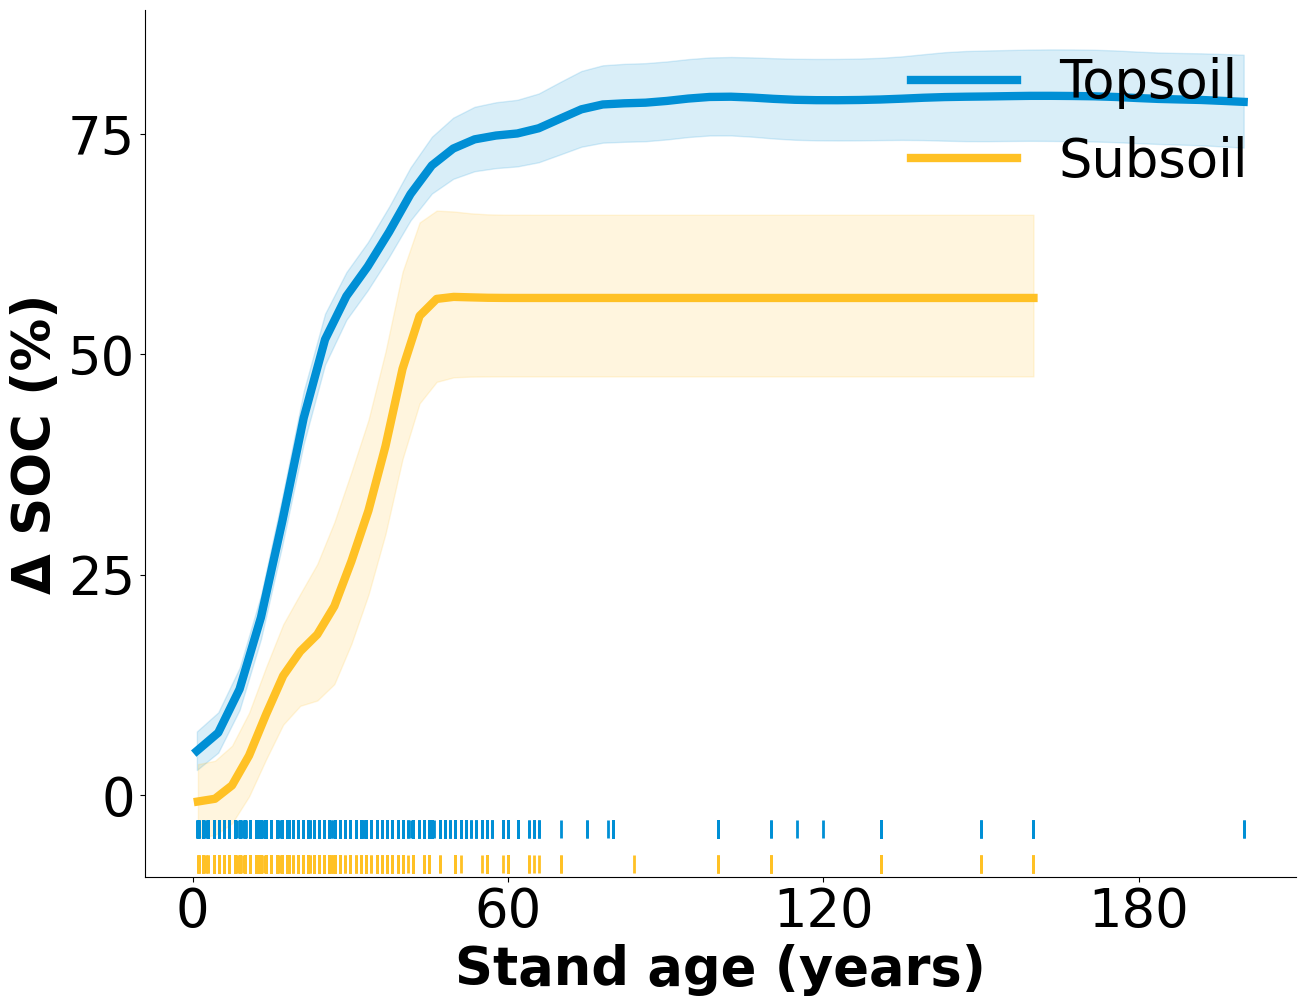

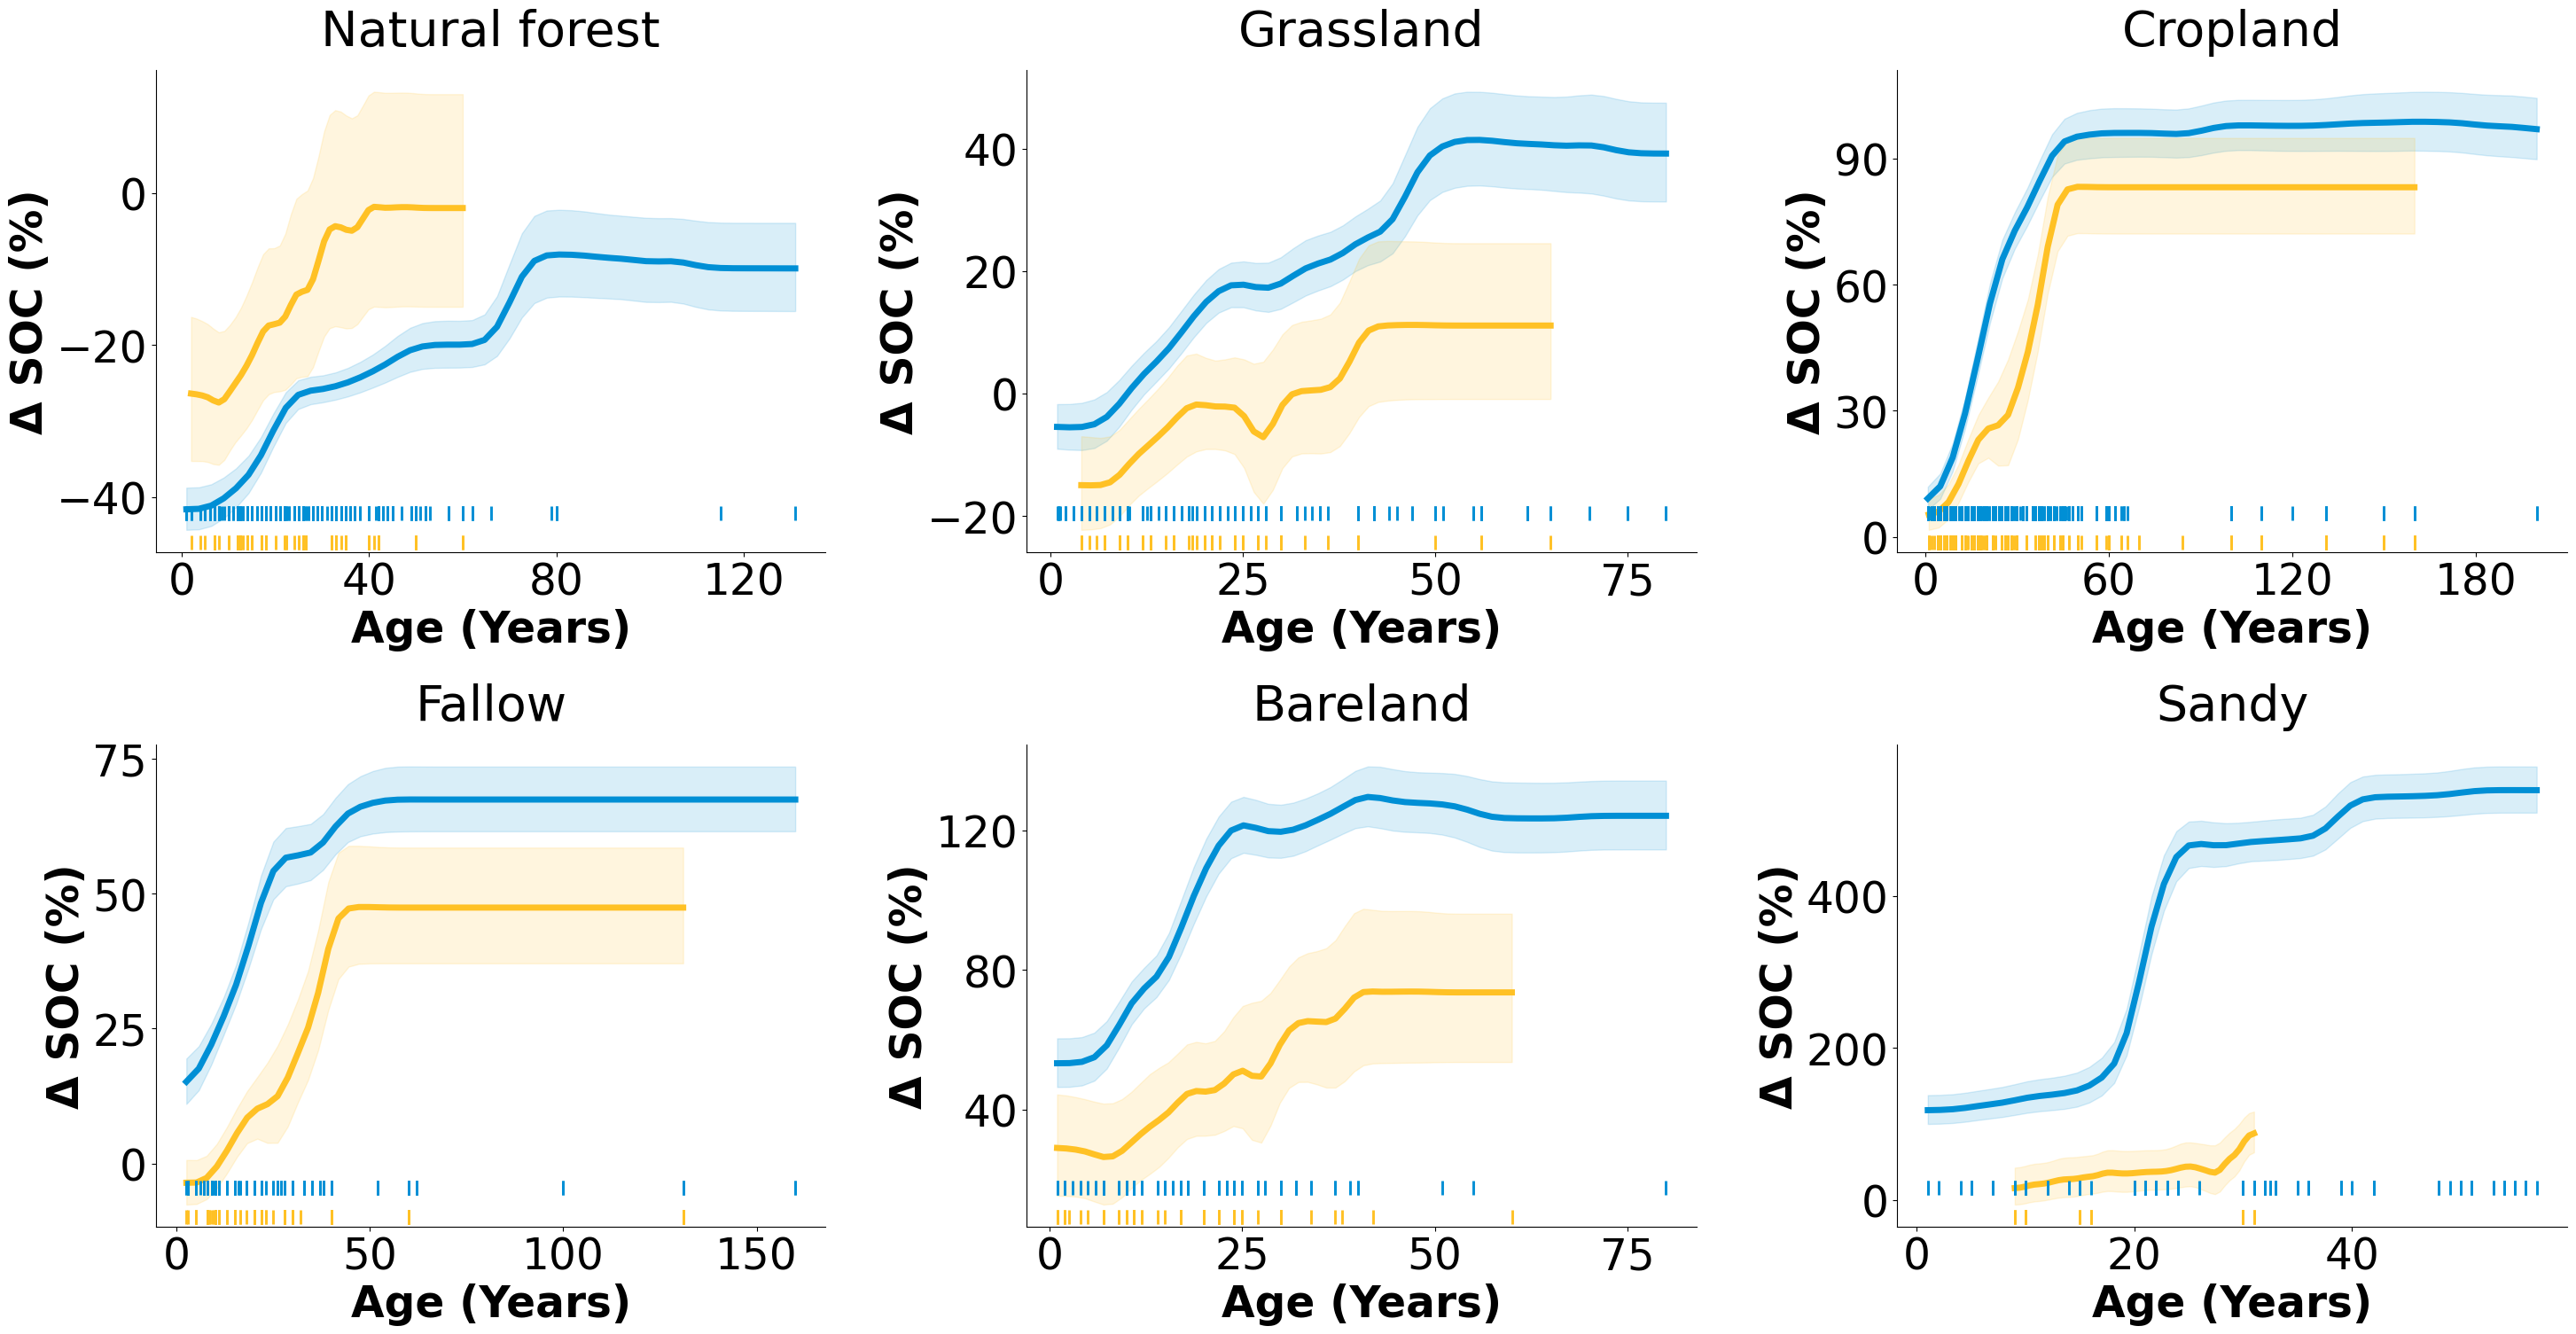

In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MaxNLocator
import os
import glob
import warnings

warnings.filterwarnings('ignore')

# ============================================================
# 1. 设置路径与参数
# ============================================================
base_dir = r'F:/model/results/sixth'
save_path = os.path.join(base_dir, 'plots')
if not os.path.exists(save_path):
    os.makedirs(save_path)

plot_data_list = []

# ============================================================
# 2. 加载特征名称与数据
# ============================================================
with open(os.path.join(base_dir, 'SOC_top/feature_names.txt'), 'r') as f:
    model_features_top = [l.strip() for l in f if l.strip()]

with open(os.path.join(base_dir, 'SOC_sub/feature_names.txt'), 'r') as f:
    model_features_sub = [l.strip() for l in f if l.strip()]

df = pd.read_csv(r'F:/model/df.clean.yi.csv')

# ============================================================
# 3. 函数定义
# ============================================================
def load_cv_models(model_dir):
    files = glob.glob(os.path.join(model_dir, 'cv_model_repeat_*_fold_*.json'))
    models = []
    for f in files:
        m = xgb.Booster()
        m.load_model(f)
        models.append(m)
    return models

def transform_yi_to_percent(yi_values):
    return (np.exp(yi_values) - 1) * 100

def create_dynamic_features(X, model_features):
    """
    Revised to ensure 'LUtype_copy' and other engineered features 
    match the training set expectations.
    """
    X_processed = X.copy()
    
    # 1. Log transformations
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X_processed.columns:
            X_processed[col + '_log'] = np.log(X_processed[col] + 1e-8)
    
    # 2. Altitude bins
    if 'Altitude' in X_processed.columns:
        X_processed['Altitude_bins'] = pd.cut(X_processed['Altitude'], bins=5, labels=False, duplicates='drop')
    
    # 3. LUtype engineered features (Fixing the missing LUtype_copy here)
    if 'LUtype' in X_processed.columns:
        # Add the missing copy feature found in your error log
        X_processed['LUtype_copy'] = X_processed['LUtype']
        
        for i in range(2): 
            X_processed[f'LUtype_boost_{i+1}'] = X_processed['LUtype']
        
        for feature in ['pH', 'BD', 'Age', 'Altitude']:
            if feature in X_processed.columns:
                X_processed[f'LUtype_{feature}_interaction'] = X_processed['LUtype'] * X_processed[feature]
        X_processed['LUtype_squared'] = X_processed['LUtype'] ** 2
    
    # IMPORTANT: Reindex to match the EXACT order of model_features
    # Fill missing with 0 if some engineered features aren't used in one of the layers
    X_final = X_processed.reindex(columns=model_features).fillna(0)
    return X_final

def calculate_pdp_with_cv_ci(cv_models, X, feature_name, grid_points=50, use_full_range=True):
    if feature_name not in X.columns:
        return None, None, None, None, None, None
    
    feature_data = X[feature_name]
    min_val = feature_data.min() if use_full_range else feature_data.quantile(0.05)
    max_val = feature_data.max() if use_full_range else feature_data.quantile(0.95)
    feature_grid = np.linspace(min_val, max_val, grid_points)
    
    all_pdps = []
    # Pre-calculate base dynamic features once to save time
    # (except the one we are varying)
    
    for model in cv_models:
        model_pdp = []
        for value in feature_grid:
            X_temp = X.copy()
            X_temp[feature_name] = value
            
            # Re-update dependent engineered features for 'Age'
            if feature_name == 'Age':
                if 'Age_log' in X_temp.columns: 
                    X_temp['Age_log'] = np.log(value + 1e-8)
                if 'LUtype_Age_interaction' in X_temp.columns: 
                    X_temp['LUtype_Age_interaction'] = X_temp['LUtype'] * value
            
            # Ensure column order matches the model
            dtemp = xgb.DMatrix(X_temp)
            model_pdp.append(np.mean(model.predict(dtemp)))
        all_pdps.append(model_pdp)
    
    all_pdps = np.array(all_pdps)
    pdp_mean = np.nanmean(all_pdps, axis=0)
    pdp_std = np.nanstd(all_pdps, axis=0)
    
    pdp_mean_s = gaussian_filter1d(pdp_mean, sigma=1.2)
    pdp_low_s = gaussian_filter1d(pdp_mean - 1.96 * pdp_std, sigma=1.2)
    pdp_upp_s = gaussian_filter1d(pdp_mean + 1.96 * pdp_std, sigma=1.2)
    
    return feature_grid, pdp_mean_s, pdp_std, pdp_low_s, pdp_upp_s, all_pdps

def get_base_features(model_features, df_columns):
    base_features = []
    for feature in model_features:
        # Check for our specific engineered suffixes
        clean_feat = feature
        for suffix in ['_log', '_boost_1', '_boost_2', '_interaction', '_squared', '_copy', '_bins']:
            if suffix in clean_feat:
                if suffix == '_interaction':
                    # Extract the part that isn't LUtype
                    parts = clean_feat.replace('_interaction', '').split('_')
                    for p in parts:
                        if p != 'LUtype' and p in df_columns: base_features.append(p)
                elif suffix == '_copy' or '_boost' in suffix or suffix == '_squared':
                    base_features.append('LUtype')
                else:
                    clean_feat = clean_feat.replace(suffix, '')
        
        if clean_feat in df_columns:
            base_features.append(clean_feat)
            
    return list(set(base_features + ['Soillayer', 'LUtype']))

# ============================================================
# 4. 数据预处理 & 计算
# ============================================================
cv_models_top = load_cv_models(os.path.join(base_dir, 'SOC_top/cv_models'))
cv_models_sub = load_cv_models(os.path.join(base_dir, 'SOC_sub/cv_models'))

lu_type_names = {1: "Cropland", 2: "Natural forest", 3: "Grassland", 4: "Bareland", 5: "Wetland", 6: "Fallow", 7: "Sandy"}
lu_types_to_plot = [2, 3, 1, 6, 4, 7]

topsoil_df = df[df['Soillayer'] == 1].copy()
subsoil_df = df[df['Soillayer'] == 2].copy()

soil_layers = [
    ('Topsoil', 1, '#008fd5', cv_models_top, model_features_top, get_base_features(model_features_top, df.columns)), 
    ('Subsoil', 2, '#FFC125', cv_models_sub, model_features_sub, get_base_features(model_features_sub, df.columns))  
]

all_results = {'Topsoil': {}, 'Subsoil': {}}
for soil_name, soil_value, soil_color, cv_models, model_features, base_features in soil_layers:
    soil_df = topsoil_df if soil_value == 1 else subsoil_df
    for lu_type in lu_types_to_plot:
        lu_df = soil_df[soil_df['LUtype'] == lu_type].copy()
        if len(lu_df) > 5:
            X_base = lu_df[base_features].copy()
            X = create_dynamic_features(X_base, model_features)
            grid, mean, std, low, upp, _ = calculate_pdp_with_cv_ci(cv_models, X, 'Age', use_full_range=True)
            all_results[soil_name][lu_type] = {
                'age': grid, 'pdp': mean, 'pdp_lower': low, 'pdp_upper': upp,
                'raw_age': lu_df['Age'].values
            }

# ============================================================
# 5. 绘图 - 总图 (Total Plot)
# ============================================================
plt.rcParams.update({'font.size': 38, 'axes.labelweight': 'bold'})
fig1, ax1 = plt.subplots(figsize=(14, 11))

for soil_name, _, soil_color, cv_models, model_features, base_features in soil_layers:
    current_df = topsoil_df if soil_name == 'Topsoil' else subsoil_df
    X = create_dynamic_features(current_df[base_features], model_features)
    grid, mean, _, low, upp, _ = calculate_pdp_with_cv_ci(cv_models, X, 'Age', use_full_range=True)
    
    p_mean = transform_yi_to_percent(mean)
    p_low = transform_yi_to_percent(low)
    p_upp = transform_yi_to_percent(upp)
    
    temp_df = pd.DataFrame({
        'Source': 'Total_Plot', 'SoilLayer': soil_name, 'LUType': 'All',
        'Age_Grid': grid, 'PDP_Percent': p_mean, 'PDP_Lower_Percent': p_low, 'PDP_Upper_Percent': p_upp
    })
    plot_data_list.append(temp_df)

    ax1.plot(grid, p_mean, color=soil_color, label=soil_name, linewidth=6, zorder=3)
    ax1.fill_between(grid, p_low, p_upp, color=soil_color, alpha=0.15, zorder=2)
    
    raw_age = current_df['Age'].values
    y_level = 0.015 if soil_name == 'Subsoil' else 0.055
    ax1.scatter(raw_age, np.full_like(raw_age, y_level), marker='|', 
                transform=ax1.get_xaxis_transform(), color=soil_color, 
                 s=150, lw=2, zorder=4)

ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.set_xlabel('Stand age (years)')
ax1.set_ylabel('Δ SOC (%)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'SOCTotal_PDP_Rug_Top.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 6. 绘图 - 子图 (Subplots)
# ============================================================
fig2, axes2 = plt.subplots(2, 3, figsize=(30, 16))
axes_flat = axes2.flatten()

for idx, lu_type in enumerate(lu_types_to_plot):
    ax = axes_flat[idx]
    ax.set_title(lu_type_names[lu_type], fontsize=40, pad=20)
    
    for soil_name, _, soil_color, _, _, _ in soil_layers:
        if lu_type in all_results[soil_name]:
            res = all_results[soil_name][lu_type]
            p_mean_sub = transform_yi_to_percent(res['pdp'])
            p_low_sub = transform_yi_to_percent(res['pdp_lower'])
            p_upp_sub = transform_yi_to_percent(res['pdp_upper'])

            temp_df_sub = pd.DataFrame({
                'Source': 'Sub_Plot', 'SoilLayer': soil_name, 'LUType': lu_type_names[lu_type],
                'Age_Grid': res['age'], 'PDP_Percent': p_mean_sub, 'PDP_Lower_Percent': p_low_sub, 'PDP_Upper_Percent': p_upp_sub
            })
            plot_data_list.append(temp_df_sub)

            ax.plot(res['age'], p_mean_sub, color=soil_color, linewidth=5)
            ax.fill_between(res['age'], p_low_sub, p_upp_sub, color=soil_color, alpha=0.15)
            
            y_level = 0.02 if soil_name == 'Subsoil' else 0.08
            ax.scatter(res['raw_age'], np.full_like(res['raw_age'], y_level), marker='|', 
                        transform=ax.get_xaxis_transform(), color=soil_color, 
                         s=130, lw=2.1, zorder=4)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.set_xlabel('Age (Years)', fontsize=35)
    ax.set_ylabel('Δ SOC (%)', fontsize=35)
    ax.tick_params(labelsize=35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig(os.path.join(save_path, 'SOCSubplots_PDP_Rug_Top.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 7. 保存数据
# ============================================================
final_plot_data = pd.concat(plot_data_list, ignore_index=True)
final_plot_data.to_csv(os.path.join(save_path, 'SOC_PDP_Plotting_Data.csv'), index=False)
print(f"Success! Data saved to: {os.path.join(save_path, 'SOC_PDP_Plotting_Data.csv')}")

plt.show()

Original max age: 200.0, Trimmed max age: 120.0
Trimmed plotting data has been saved to: F:/model/results/LI\plots\LI_PDP_Plotting_Data_Trimmed.csv


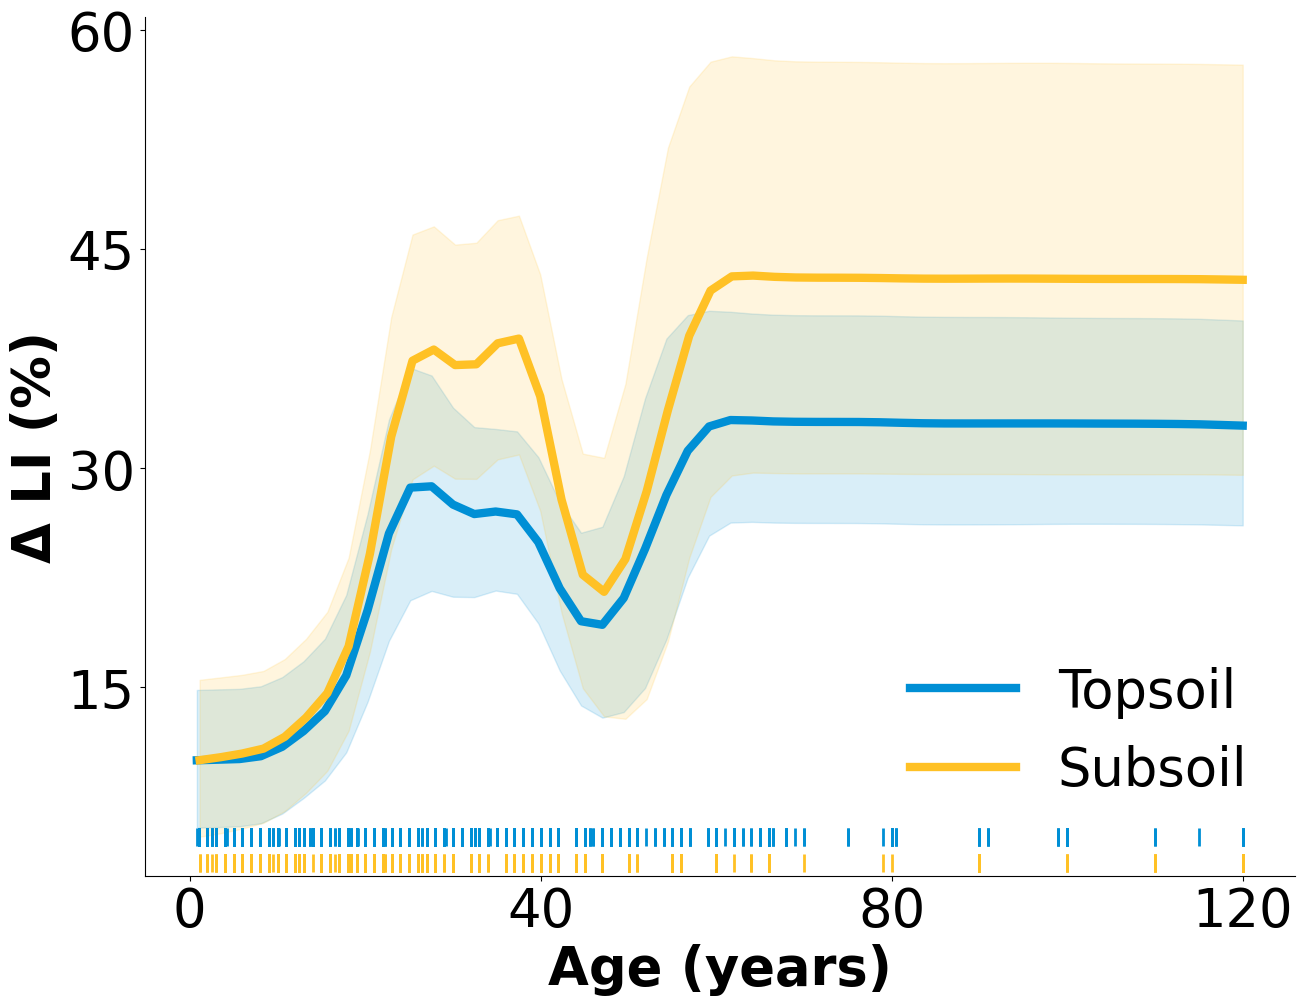

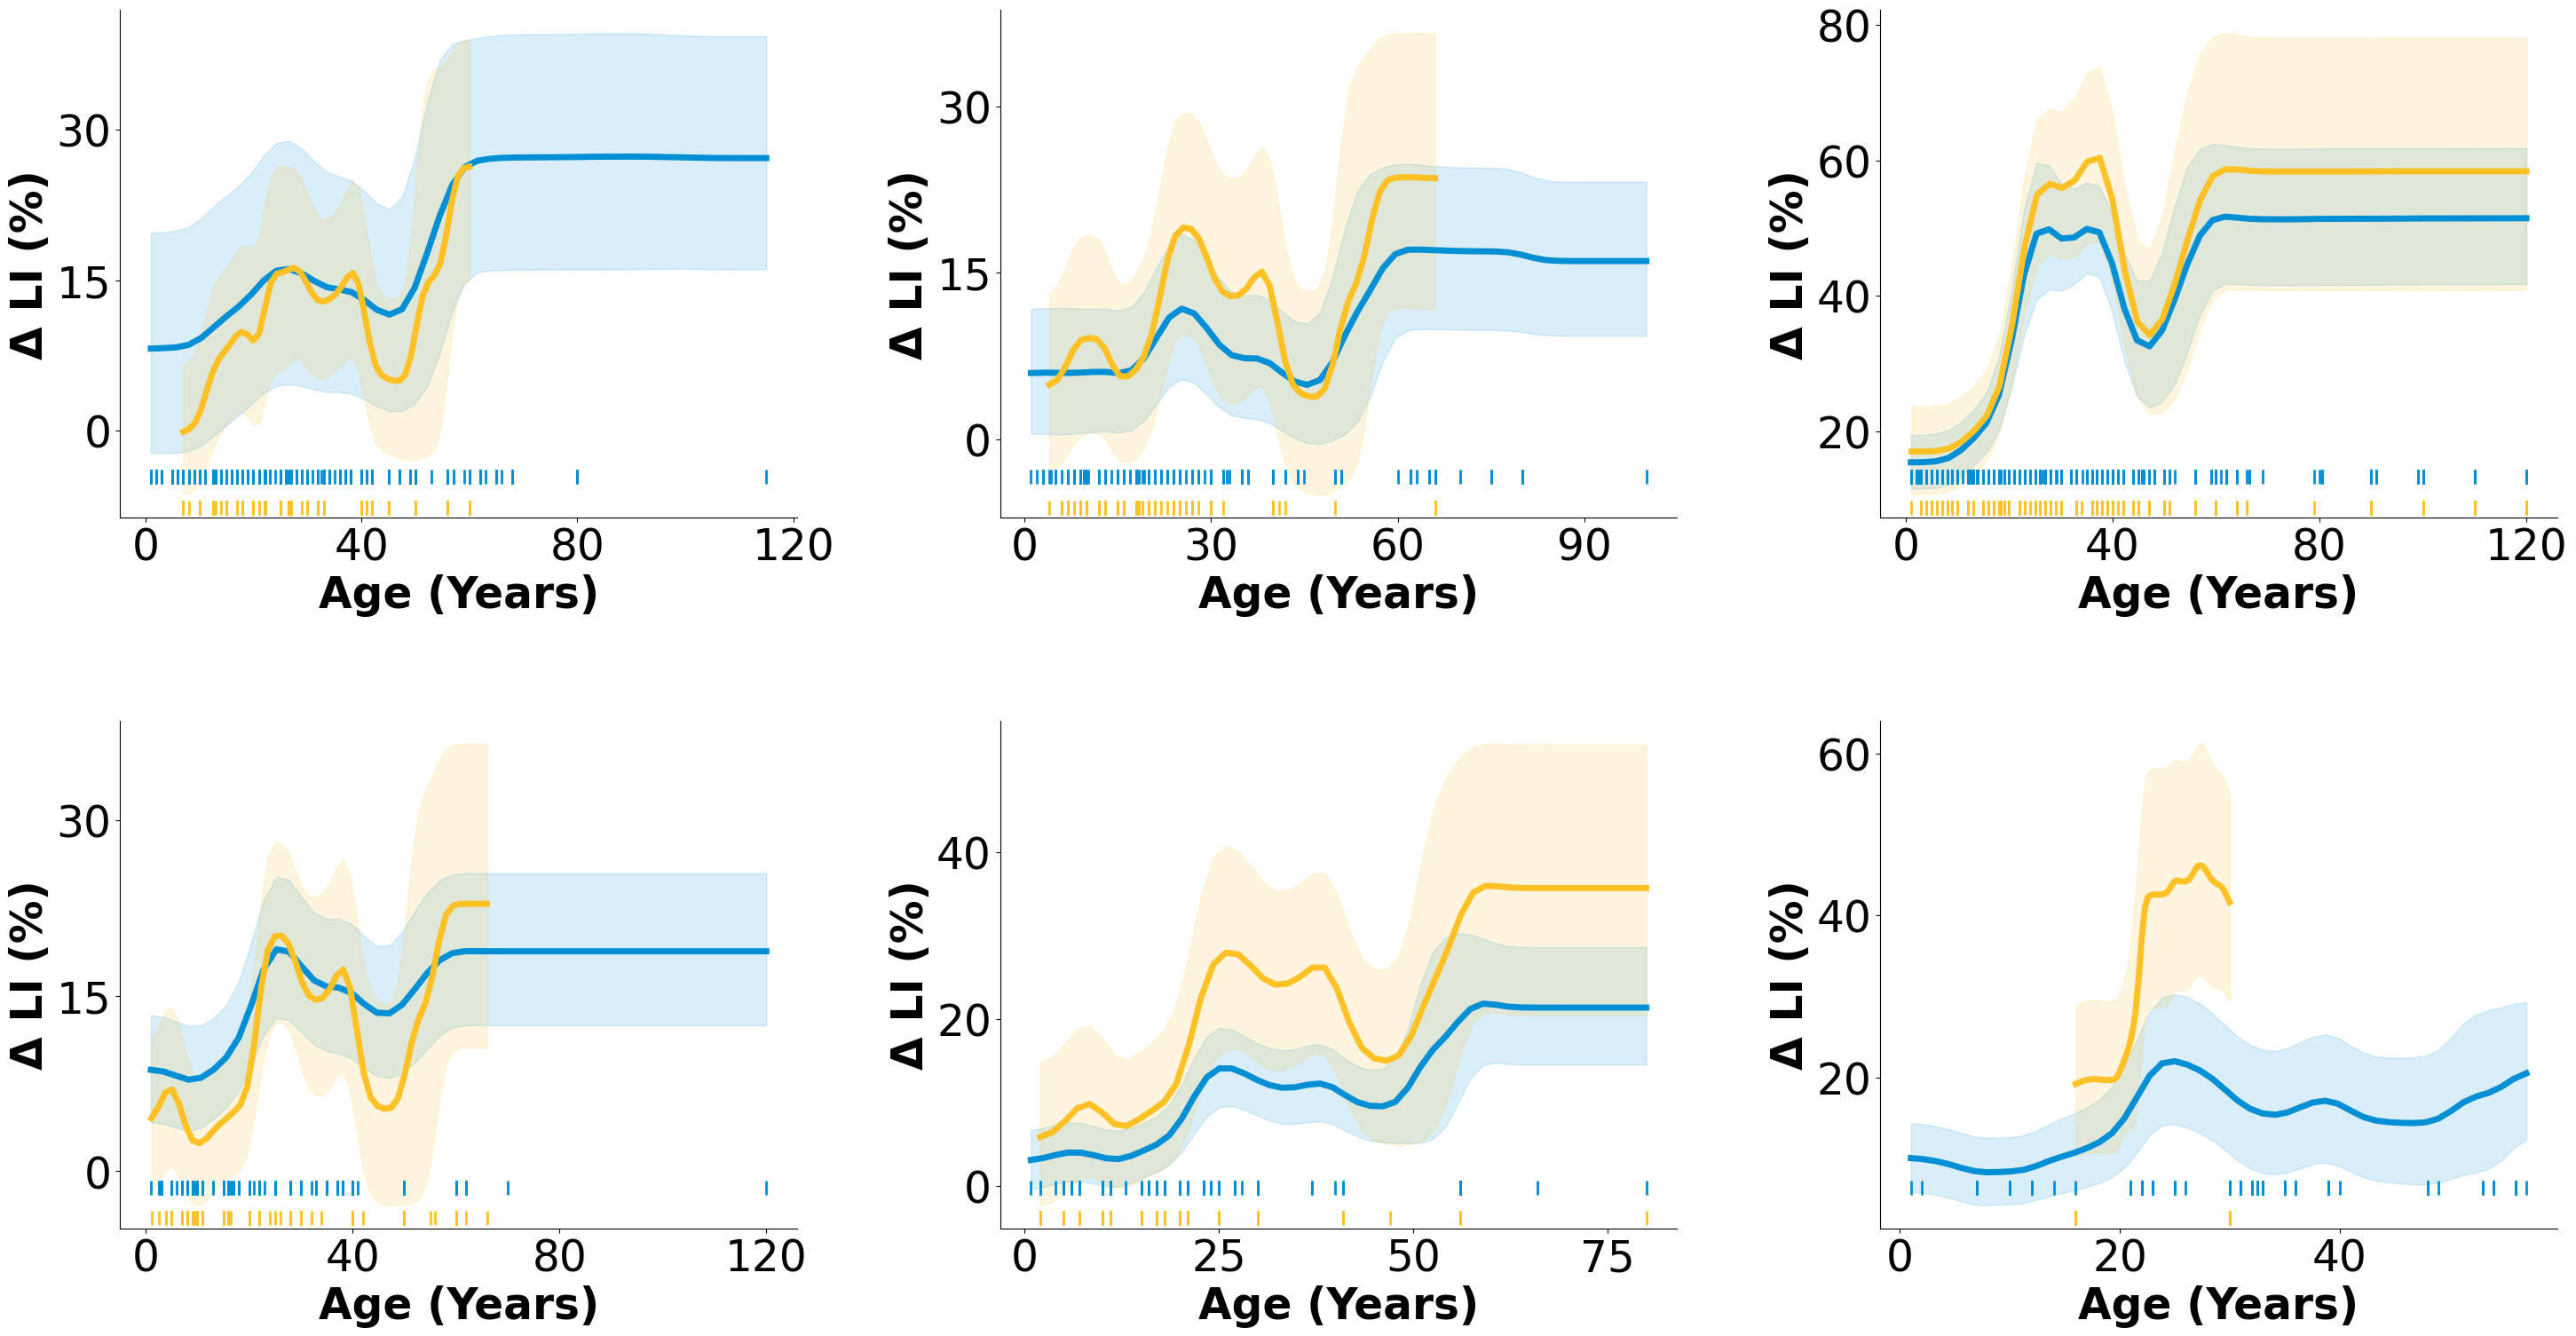

In [15]:
##Partial dependance plot
#LI with rugs fixed results saved - Tail data trimmed 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MaxNLocator
import os
import glob
import warnings

warnings.filterwarnings('ignore')

# ============================================================
# 1. 设置路径与参数
# ============================================================
base_dir = r'F:/model/results/LI'
save_path = os.path.join(base_dir, 'plots')
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 用于存储所有绘图原始数据的列表
plot_data_list = []

# ============================================================
# 2. 加载特征名称与数据
# ============================================================
with open(os.path.join(base_dir, 'LI_top/feature_names.txt'), 'r') as f:
    model_features_top = [l.strip() for l in f if l.strip()]

with open(os.path.join(base_dir, 'LI_sub/feature_names.txt'), 'r') as f:
    model_features_sub = [l.strip() for l in f if l.strip()]

df = pd.read_csv(r'F:/model/df.clean.yi.LI.csv')

# ============================================================
# 3. 函数定义 (保持不变)
# ============================================================
def load_cv_models(model_dir):
    files = glob.glob(os.path.join(model_dir, 'cv_model_repeat_*_fold_*.json'))
    models = []
    for f in files:
        m = xgb.Booster()
        m.load_model(f)
        models.append(m)
    return models

def transform_yi_to_percent(yi_values):
    return (np.exp(yi_values) - 1) * 100

def create_dynamic_features(X, model_features):
    X_processed = X.copy()
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X_processed.columns:
            X_processed[col + '_log'] = np.log(X_processed[col] + 1e-8)
    
    if 'Altitude' in X_processed.columns:
        X_processed['Altitude_bins'] = pd.cut(X_processed['Altitude'], bins=5, labels=False, duplicates='drop')
    
    if 'LUtype' in X_processed.columns:
        for i in range(2): 
            X_processed[f'LUtype_boost_{i+1}'] = X_processed['LUtype']
        
        for feature in ['pH', 'BD', 'Age', 'Altitude']:
            if feature in X_processed.columns:
                X_processed[f'LUtype_{feature}_interaction'] = X_processed['LUtype'] * X_processed[feature]
        X_processed['LUtype_squared'] = X_processed['LUtype'] ** 2
    
    available_features = [feat for feat in model_features if feat in X_processed.columns]
    return X_processed[available_features]

def calculate_pdp_with_cv_ci(cv_models, X, feature_name, grid_points=50, use_full_range=True):
    if feature_name not in X.columns:
        return None, None, None, None, None, None
    
    feature_data = X[feature_name]
    min_val = feature_data.min()
    max_val = feature_data.max()
    feature_grid = np.linspace(min_val, max_val, grid_points)
    
    all_pdps = []
    for model in cv_models:
        model_pdp = []
        for value in feature_grid:
            X_temp = X.copy()
            X_temp[feature_name] = value
            if feature_name == 'Age':
                if 'Age_log' in X_temp.columns: X_temp['Age_log'] = np.log(value + 1e-8)
                if 'LUtype_Age_interaction' in X_temp.columns: X_temp['LUtype_Age_interaction'] = X_temp['LUtype'] * value
            
            dtemp = xgb.DMatrix(X_temp)
            model_pdp.append(np.mean(model.predict(dtemp)))
        all_pdps.append(model_pdp)
    
    all_pdps = np.array(all_pdps)
    pdp_mean = np.nanmean(all_pdps, axis=0)
    pdp_std = np.nanstd(all_pdps, axis=0)
    
    pdp_mean_s = gaussian_filter1d(pdp_mean, sigma=1.2)
    pdp_low_s = gaussian_filter1d(pdp_mean - 1.96 * pdp_std, sigma=1.2)
    pdp_upp_s = gaussian_filter1d(pdp_mean + 1.96 * pdp_std, sigma=1.2)
    
    return feature_grid, pdp_mean_s, pdp_std, pdp_low_s, pdp_upp_s, all_pdps

def get_base_features(model_features, df_columns):
    base_features = []
    for feature in model_features:
        if '_log' in feature: base_features.append(feature.replace('_log', ''))
        elif '_interaction' in feature:
            for part in feature.split('_'):
                if part in df_columns and part not in ['LUtype', 'interaction']: base_features.append(part)
        elif '_boost' in feature: base_features.append('LUtype')
        elif feature in df_columns: base_features.append(feature)
    return list(set(base_features + ['Soillayer', 'LUtype']))

# ============================================================
# 4. 数据预处理 - 包含 Age 尾部剔除
# ============================================================
cv_models_top = load_cv_models(os.path.join(base_dir, 'LI_top/cv_models'))
cv_models_sub = load_cv_models(os.path.join(base_dir, 'LI_sub/cv_models'))

lu_type_names = {1: "Cropland", 2: "Natural forest", 3: "Grassland", 4: "Bareland", 5: "Wetland", 6: "Fallow", 7: "Sandy"}
lu_types_to_plot = [2, 3, 1, 6, 4, 7]

# --- 核心修改：剔除 Age 最大的 1% 数据 (零星离群值) ---
age_threshold = df['Age'].quantile(0.99)
df_trimmed = df[df['Age'] <= age_threshold].copy()
print(f"Original max age: {df['Age'].max()}, Trimmed max age: {df_trimmed['Age'].max()}")

topsoil_df = df_trimmed[df_trimmed['Soillayer'] == 1].copy()
subsoil_df = df_trimmed[df_trimmed['Soillayer'] == 2].copy()

soil_layers = [
    ('Topsoil', 1, '#008fd5', cv_models_top, model_features_top, get_base_features(model_features_top, df.columns)), 
    ('Subsoil', 2, '#FFC125', cv_models_sub, model_features_sub, get_base_features(model_features_sub, df.columns))  
]

# 计算结果缓存
all_results = {'Topsoil': {}, 'Subsoil': {}}
for soil_name, soil_value, soil_color, cv_models, model_features, base_features in soil_layers:
    soil_df = topsoil_df if soil_value == 1 else subsoil_df
    for lu_type in lu_types_to_plot:
        lu_df = soil_df[soil_df['LUtype'] == lu_type].copy()
        if len(lu_df) > 5:
            X_base = lu_df[base_features].copy()
            X = create_dynamic_features(X_base, model_features)
            grid, mean, std, low, upp, _ = calculate_pdp_with_cv_ci(cv_models, X, 'Age', use_full_range=True)
            all_results[soil_name][lu_type] = {
                'age': grid, 'pdp': mean, 'pdp_lower': low, 'pdp_upper': upp,
                'raw_age': lu_df['Age'].values
            }

# ============================================================
# 5. 绘图 - 总图 (基于裁剪后的数据)
# ============================================================
plt.rcParams.update({'font.size': 38, 'axes.labelweight': 'bold'})
fig1, ax1 = plt.subplots(figsize=(14, 11))

for soil_name, _, soil_color, cv_models, model_features, base_features in soil_layers:
    current_df = topsoil_df if soil_name == 'Topsoil' else subsoil_df
    X = create_dynamic_features(current_df[base_features], model_features)
    grid, mean, _, low, upp, _ = calculate_pdp_with_cv_ci(cv_models, X, 'Age', use_full_range=True)
    
    p_mean = transform_yi_to_percent(mean)
    p_low = transform_yi_to_percent(low)
    p_upp = transform_yi_to_percent(upp)
    
    # 记录总图数据
    temp_df = pd.DataFrame({
        'Source': 'Total_Plot',
        'SoilLayer': soil_name,
        'LUType': 'All',
        'Age_Grid': grid,
        'PDP_Percent': p_mean,
        'PDP_Lower_Percent': p_low,
        'PDP_Upper_Percent': p_upp
    })
    plot_data_list.append(temp_df)

    ax1.plot(grid, p_mean, color=soil_color, label=soil_name, linewidth=6, zorder=3)
    ax1.fill_between(grid, p_low, p_upp, color=soil_color, alpha=0.15, zorder=2)
    
    # --- 地毯图 (仅显示裁剪后的点) ---
    raw_age = current_df['Age'].values
    y_level = 0.015 if soil_name == 'Subsoil' else 0.045
    ax1.scatter(raw_age, np.full_like(raw_age, y_level), marker='|', 
                transform=ax1.get_xaxis_transform(), color=soil_color, 
                 s=150, lw=2, zorder=4)

ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.set_xlabel('Age (years)')
ax1.set_ylabel('Δ LI (%)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.0, 0.3))
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'LI_Total_PDP_Trimmed.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 6. 绘图 - 子图 (基于裁剪后的数据)
# ============================================================
fig2, axes2 = plt.subplots(2, 3, figsize=(30, 16))
axes_flat = axes2.flatten()

for idx, lu_type in enumerate(lu_types_to_plot):
    ax = axes_flat[idx]
    
    for soil_name, _, soil_color, _, _, _ in soil_layers:
        if lu_type in all_results[soil_name]:
            res = all_results[soil_name][lu_type]
            p_mean_sub = transform_yi_to_percent(res['pdp'])
            p_low_sub = transform_yi_to_percent(res['pdp_lower'])
            p_upp_sub = transform_yi_to_percent(res['pdp_upper'])

            # 记录子图数据
            temp_df_sub = pd.DataFrame({
                'Source': 'Sub_Plot',
                'SoilLayer': soil_name,
                'LUType': lu_type_names[lu_type],
                'Age_Grid': res['age'],
                'PDP_Percent': p_mean_sub,
                'PDP_Lower_Percent': p_low_sub,
                'PDP_Upper_Percent': p_upp_sub
            })
            plot_data_list.append(temp_df_sub)

            ax.plot(res['age'], p_mean_sub, color=soil_color, linewidth=5)
            ax.fill_between(res['age'], p_low_sub, p_upp_sub, color=soil_color, alpha=0.15)
            
            y_level = 0.02 if soil_name == 'Subsoil' else 0.08
            ax.scatter(res['raw_age'], np.full_like(res['raw_age'], y_level), marker='|', 
                        transform=ax.get_xaxis_transform(), color=soil_color, 
                         s=130, lw=2, zorder=4)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.set_xlabel('Age (Years)', fontsize=35)
    ax.set_ylabel('Δ LI (%)', fontsize=35)
    ax.tick_params(labelsize=35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig(os.path.join(save_path, 'LI_Subplots_PDP_Trimmed.png'), dpi=300, bbox_inches='tight')

# ============================================================
# 7. 最终保存绘图数据到 CSV
# ============================================================
final_plot_data = pd.concat(plot_data_list, ignore_index=True)
final_plot_data.to_csv(os.path.join(save_path, 'LI_PDP_Plotting_Data_Trimmed.csv'), index=False)
print(f"Trimmed plotting data has been saved to: {os.path.join(save_path, 'LI_PDP_Plotting_Data_Trimmed.csv')}")

plt.show()